# <center>**Fake News Detection using LSTM**</center>


<center><img src="images/fakenews_top.jpg" width="500"/></center>
<center><font size="1"> Author: Brandon Lasher</font>&emsp;&emsp;
<font size="1"> Contact: bl7@hood.edu</font></center><br>

#### <u>Sections</u> ( Note: the bookmarks do not work on github )
- <a href=#includes>Includes</a>
- <a href=#inspect>Inspect and clean the data</a>
    -  Dataset link: [https://www.kaggle.com/code/josutk/only-one-word-99-2/data](https://www.kaggle.com/code/josutk/only-one-word-99-2/data)
- <a href=#vis>Visualizations of the data</a>
    - <a href=#der>Deriving New Features</a>
    - <a href=#ngram>N-gram Analysis</a>
    - <a href=#word>WordClouds</a>
- <a href=#model>Model Creation</a>
    - <a href=#lstm>LSTM Creation</a>
- <a href=#test>Test Data Set</a>
    - Second dataset: [https://www.kaggle.com/competitions/fake-news/data](https://www.kaggle.com/competitions/fake-news/data)
- <a href=#conclu>Conclustions</a>
    

#### <u>Description of Problem</u>
Due to the widespread acceptance of social media as a source of news, fake news has become far more prevalent. People share stories on these platforms to their networks with little or no idea if these stories are indeed true or false. This has impacted and is still impacting societies around the world. And this had led to need for a process in which to automatically identify which news articles are fake and which are true. 

#### <u>Approach</u>
This project will train a Long short-term memory (LSTM) neural network to use to identify fake news as compared to true news.  First, we will clean the data of URLs, punctuation, return lines, and numbers. Next, during this process we will look at other features of the training data set such as polarity and subjectivity of the text, n-gram analysis and word clouds.  Then we will build an LSTM model based on the training data. Lastly, we will take a new dataset, from a fake news detection contest on Kaggle, and we will run it against our model to see how it holds up.

#### <u>Findings</u>
Using the test data set, a subsection of the overall dataset, we found our model to have a >99% accuracy. However, when we run it against second dataset, independent from the one we used to train, we found it was only >74% accurate. When running on the independent dataset I found it improved when I included the author of the material in the text. (This also better matched the training dataset). Also, the second dataset does not provide a date to see a publication timeframe and I did not check for overlapping stories.<br>
Dataset insights:
- Fake news was noticeably more subjective (less objective) than true news
- Fake news was heavily centered around Donald Trump
- The news source can play a part in the detection



*****
## Includes
<a id='includes'></a>

In [1]:
#Turn off some the graph warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#Basic libraries
import pandas as pd
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud,STOPWORDS
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#plt.rcParams['figure.figsize'] = [10, 5]

#For iplot of series
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

import re
import string

#Stop words
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

import gensim
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Conv1D,MaxPool1D


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


****
## Inspect and clean the data
- Data can be found from this kaggle project [https://www.kaggle.com/code/josutk/only-one-word-99-2/data](https://www.kaggle.com/code/josutk/only-one-word-99-2/data)
<a id='inspect'></a>

In [2]:
#Reading the fake and true datasets
fake_news = pd.read_csv('data/Fake.csv')
true_news = pd.read_csv('data/True.csv')

#Print shape of the datasets with rows and columns and information 
print ("The shape of the  fake news dataset is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")


print ("The shape of the true news dataset is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  fake news dataset is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the true news dataset is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


**Insights:**
- All the counts match the index range, which mean no null data entries.

In [3]:
fake_news['date'].value_counts()

May 10, 2017         46
May 26, 2016         44
May 6, 2016          44
May 5, 2016          44
May 11, 2016         43
                     ..
December 9, 2017      1
December 4, 2017      1
November 19, 2017     1
November 20, 2017     1
Jul 19, 2015          1
Name: date, Length: 1681, dtype: int64

In [4]:
#Concatenating title+text and dropping orignal columns
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)


true_news = true_news.drop(8970,axis=0) # drop due to image

true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Adding Classifier flag
fake_news['type'] = 0
true_news['type'] = 1

#Rearranging the column order
fake_news = fake_news[['subject', 'date', 'news','type']]
true_news = true_news[['subject', 'date', 'news','type']]


#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

true_news=true_news[~true_news.date.str.contains("http")]
true_news=true_news[~true_news.date.str.contains("HOST")]


#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])


Checking the dates of publication just to see if there is any correlation trend

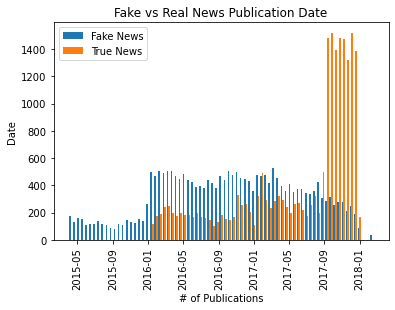

In [5]:

plt.hist([fake_news['date'], true_news['date']], bins=75)
plt.title("Fake vs Real News Publication Date")
plt.xlabel("# of Publications")
plt.ylabel("Date")

plt.legend(["Fake News", "True News"])
plt.xticks(rotation = 90)

plt.show();

**Insights:**
- It appears that the datasets we have are slight biased in time. The fake news seems to be evenly distributed where as the true news is much more recent. 
- If the topic of the news is an indicator of fake vs true, and the fact these are not both distriubted evenly could allow for bias

Append the datasets for processing

In [6]:
full_dataset = pd.concat([fake_news, true_news])

Cleaning punctuation, links, numbers and making everything lowercase

In [7]:
#Create a copy 
clean_data=full_dataset.copy()

#Cleaning punctuation, links, numbers and making everything lowercase
def cleantext(text):   

    #Html tags, urls
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('https?://\S+|www\.\S+', ' ', text)
    text = re.sub('<.*?>+', ' ', text)    

    #additonal punc
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

    #Returns and numbers
    text = re.sub('\n', ' ', text)
    text = re.sub('\r', ' ', text)
    text = re.sub('\w*\d\w*', '', text)

    text = str(text).lower()
    return text

clean_data['news']=clean_data['news'].apply(lambda x:cleantext(x))
clean_data.head()

,subject,date,news,type
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


Remove commonly  stop words which add noise to our analysis. Stop words are words such as 'the', 'a' or 'in'. The NLTK has a list of stopwords for 16 different languages which we will use here.

In [8]:
stop = stopwords.words('english')
clean_data['news'] = clean_data['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_data.head()

,subject,date,news,type
0,News,2017-12-31,donald trump sends embarrassing new year’s eve...,0
1,News,2017-12-31,drunk bragging trump staffer started russian c...,0
2,News,2017-12-30,sheriff david clarke becomes internet joke thr...,0
3,News,2017-12-29,trump obsessed even obama’s name coded website...,0
4,News,2017-12-25,pope francis called donald trump christmas spe...,0


******
## Visualizations of the data
<a id='vis'></a>

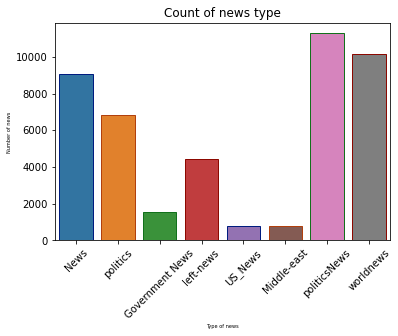

In [9]:
#Plotting the subject matter
ax = sns.countplot(x="subject", data=clean_data,
                   edgecolor=sns.color_palette("dark", 4))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(5)
ax.yaxis.get_label().set_fontsize(5)
plt.xticks(rotation=45)
plt.show()

**Insights:**
- Politics and Politic News dominate our dataset
- Some the catagories are repetitive ( ie. Politics, Politic News and US News, Government News )

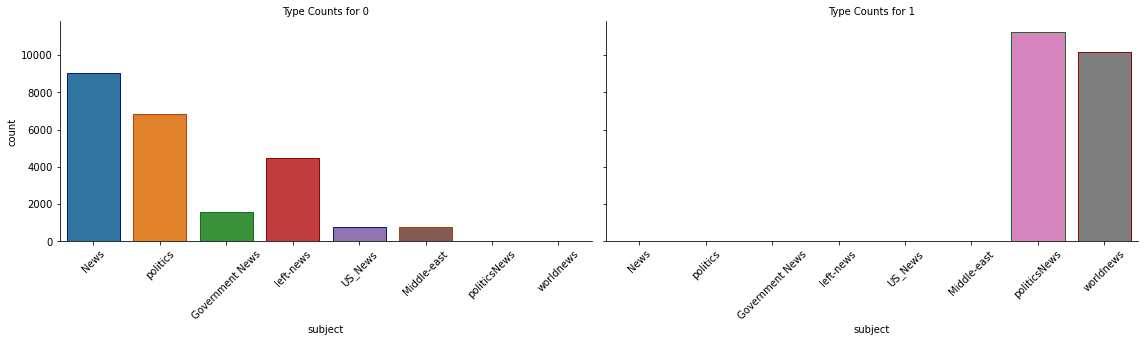

In [10]:
catp = sns.catplot(x="subject", col="type",
                data=clean_data, kind="count",
                edgecolor=sns.color_palette("dark", 4),
                height=4, aspect=2)

#Rotating the xlabels
catp.set_xticklabels(rotation=45)
catp.set_titles("Type Counts for {col_name}")
plt.show()

### Deriving New Features
- Sentiment of the news 
- polarity - How negative (-1) or positive (+1) the sentiment of the text. 
- subjectivity - Subjectivity quantifies the amount of personal opinion and factual information contained in the text. Specifically, adverb used as modifiers. 
- Word Count of the news which might be effected by the source, so I added this as a feature
<a id='der'></a>


In [11]:
clean_data['polarity'] = clean_data['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_data['subjectivity'] = clean_data['news'].map(lambda text: TextBlob(text).sentiment.subjectivity)
clean_data['word_count'] = clean_data['news'].apply(lambda x: len(str(x).split()))

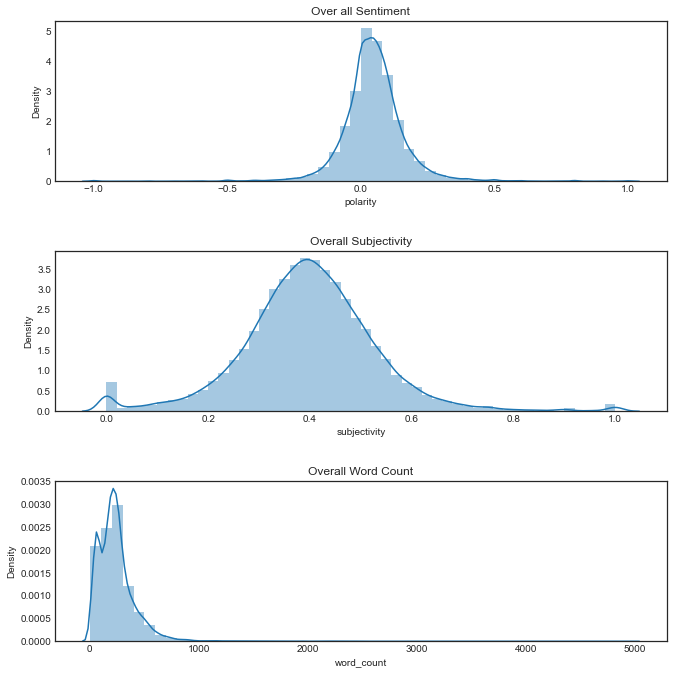

In [12]:
plt.figure(figsize = (10, 10))
plt.style.use('seaborn-white')
plt.subplot(311)
sns.distplot(clean_data['polarity'])
plt.title( 'Over all Sentiment' )
fig = plt.gcf()
fig.tight_layout(pad=3.0)

plt.subplot(312)
sns.distplot(clean_data['subjectivity'])
plt.title( 'Overall Subjectivity' )
fig = plt.gcf()
fig.tight_layout(pad=3.0)

plt.subplot(313)
sns.distplot(clean_data['word_count'])
plt.title( 'Overall Word Count' )
fig = plt.gcf()
fig.tight_layout(pad=3.0)

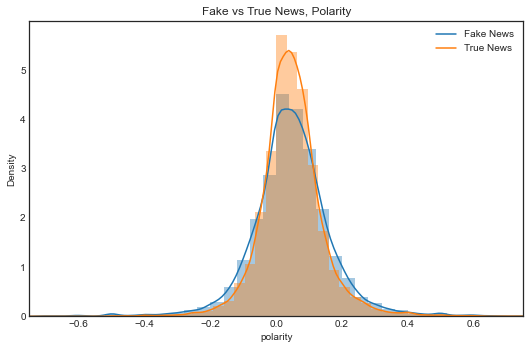

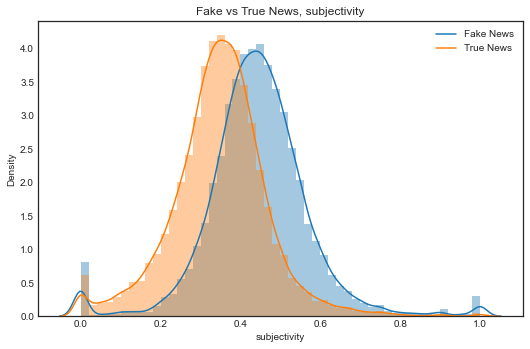

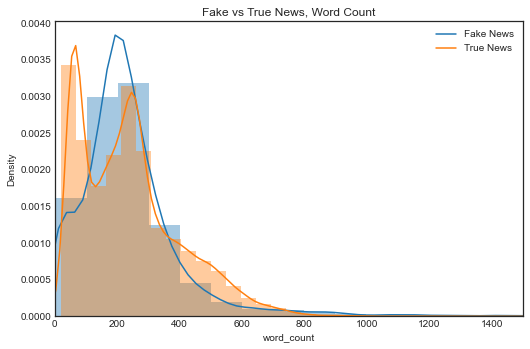

In [13]:
fake_pol = clean_data.loc[clean_data["type"] == 0, 'polarity']
true_pol = clean_data.loc[clean_data["type"] == 1, 'polarity']

fake_sub = clean_data.loc[clean_data["type"] == 0, 'subjectivity']
true_sub = clean_data.loc[clean_data["type"] == 1, 'subjectivity']

fake_wc = clean_data.loc[clean_data["type"] == 0, 'word_count']
true_wc = clean_data.loc[clean_data["type"] == 1, 'word_count']

plt.figure(figsize = (8, 10))
plt.style.use('seaborn-white')
plt.subplot(211)
sns.distplot( fake_pol  )
sns.distplot( true_pol )
plt.xlim(-.75,.75)
plt.legend(['Fake News','True News'])
plt.title('Fake vs True News, Polarity')
fig = plt.gcf()
fig.tight_layout(pad=3.0)

plt.figure(figsize = (8, 10))
plt.style.use('seaborn-white')
plt.subplot(212)
sns.distplot( fake_sub  )
sns.distplot( true_sub )
plt.legend(['Fake News','True News'])
plt.title('Fake vs True News, subjectivity')
fig = plt.gcf()
fig.tight_layout(pad=3.0)

plt.figure(figsize = (8, 10))
plt.style.use('seaborn-white')
plt.subplot(212)
sns.distplot( fake_wc  )
sns.distplot( true_wc )
plt.xlim(0,1500)
plt.legend(['Fake News','True News'])
plt.title('Fake vs True News, Word Count')
fig = plt.gcf()
fig.tight_layout(pad=3.0)


**Insights:**
- The distrubution of the sentiment on the fake news is very slightly more distributed. Both have are bias toward the positive. -1 being negative sentiment and 1 being positive sentiment.
- The distrubtution of subjectivity, clearly shows that the fake news is presented with more 'intensity'. subjectivity looks for more adverbs used as modifiers
- The word count does not give much information besides that most of the stories are below 1000 words and that the fake news tends to have a mean of approx 250 words. 

****
### N-gram Analysis
We will use this to look at what is a common topic in each of the data sets.
- First we will look at the most common word occurances
- Second we will look at the most common word pairs
- Third will will look at the most common 3 word sets
<a id='ngram'></a>


#### Top Word Occurance

In [14]:
def get_top_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_words(clean_data['news'], 20)

print("WHAT!")
 
#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

WHAT!
trump 148098
said 133027
president 57266
would 55649
people 42390
one 38584
state 35481
new 32223
also 31392
obama 31256
clinton 30341
reuters 29539
house 29401
government 28568
donald 28366
states 27067
republican 26581
year 25358
could 24415
white 24396


In [19]:
#Creating the dataframe of word and frequency
df_single = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
#df_single.groupby('news').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top words')
df_single_groups = df_single.groupby('news').sum()['count'].sort_values(ascending=False)
df_single_groups.iplot(kind='bar', title='Top words')
plt.show()


#### Top Bi-grams


In [16]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 bigrams
common_words = get_top_n_bigram(clean_data['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

donald trump 26568
united states 18900
white house 15988
hillary clinton 10102
new york 8537
featured image 7677
north korea 7241
president donald 6976
image via 6329
twitter com 6220
pic twitter 6148
barack obama 5755
year old 5111
president trump 5025
trump said 4972
prime minister 4810
last year 4746
last week 4725
supreme court 4668
said statement 4537


In [17]:
#Creating the dataframe of word and frequency
df_double = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
fig = df_double.groupby('news').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top bigrams')

#### Top Tri-grams

In [ ]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 trigrams
common_words = get_top_n_trigram(clean_data['news'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)


In [ ]:
#Creating a dataframe with words and count
df_triple = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Grouping the words and plotting their frequencies
df_triple.groupby('news').sum()['count'].sort_values(ascending=False).iplot(kind='bar', yTitle='Count', linecolor='black', title='Top trigrams')

Insights:
- During the 2016 election news cycle, it is expected that most of the news would be about Trump, Clinton or Obama.
- In the tri-grams and the bi-grams we can see common news topics were BLM, because of the death of Floyd; North korea, Russian President Vladimir Putin, 
- We also see the Donald Trump's twitter account shows up in the top 5 tri-grams. 

****
## WordClouds
<a id='word'></a>

In [ ]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(
        width = 600,
        height = 400,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(text))
    fig = plt.figure(
        figsize = (30, 20),
        facecolor = 'w',
        edgecolor = 'w')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=35, y=-0.03, x=.95)
    plt.show()
clean_data.loc[clean_data["type"] == 0, 'subjectivity']

print( )
create_wordcloud( clean_data["news"], "Full Data Set" )
create_wordcloud( clean_data.loc[clean_data["type"] == 0, 'news'], "Fake News" )
create_wordcloud( clean_data.loc[clean_data["type"] == 1, 'news'], "True News" )

****
## Model Creation
<a id='model'></a>

In [ ]:
from sklearn.model_selection import train_test_split

#create training vectors
X = [d.split() for d in clean_data['news'].tolist()]
y = clean_data['type'].values


In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
# Word2Vec is a 2 layer neural network that processes text by vectorizing words
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=10, min_count=1)

In [ ]:
len(w2v_model.wv.index_to_key)

In [ ]:
w2v_model.wv.most_similar("trump")

In [ ]:
w2v_model.wv.most_similar("president")

### Creating the LSTM Model
<a id='lstm'></a>

In [ ]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)
#Remove some of the noise from the display
#tokenizer.word_index

In [ ]:
len(X)

In [ ]:
#Configure the embedding vectors for the vocab. to help with the LSTM process. 
maxlen = 1000
X = pad_sequences(X,maxlen=maxlen)

vocab = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1 ## add 1 for unknown words


def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    
    for word,i in vocab.items():
        weight_matrix[i] = model.wv[word]
        
    return weight_matrix
    
embedding_vectors = get_weight_matrix(w2v_model)

In [ ]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#Configure the model
model = Sequential()
model.add(Embedding(vocab_size,output_dim=EMBEDDING_DIM,weights = [embedding_vectors],input_length = maxlen , trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])


In [ ]:
model.summary()

Train the model with the dataset

In [ ]:
model.fit(X_train,y_train,validation_split=0.3,epochs=1)

Check the accuracy of the model using the test part of the dataset

In [ ]:
y_pred = (model.predict(X_test)>=0.5).astype(int)
accuracy_test = accuracy_score(y_test,y_pred)
accuracy_test

*****
## Create a testcase from a new dataset

Link to the dataset: [https://www.kaggle.com/competitions/fake-news/data](https://www.kaggle.com/competitions/fake-news/data)
<a id='test'></a>

**Dataset Information**<br>
&emsp;*id:* unique id for a news article<br>
&emsp;*title:* the title of a news article<br>
&emsp;*author:* author of the news article<br>
&emsp;*text:* the text of the article; could be incomplete<br>
&emsp;*label:* a label that marks the article as potentially unreliable<br>
&emsp;&emsp;*1:* unreliable<br>
&emsp;&emsp;*0:* reliable<br>


**Notes**
- The new data data is formatted differently 
- The labels are reversed from what I trained with
- Many Null text/title fields
- I did not check for overlapping entries with my trained data



In [ ]:
#Clean and format the test csv
test_news = pd.read_csv('data/model_test.csv')

#Concatenating title+text and dropping orignal columns
test_news['news']=test_news['title']+test_news['text']+test_news['author']

#Rearranging the column order
test_news = test_news[[ 'news','label']]

clean_test=test_news.copy()
#Some entries have null text/title
clean_test.dropna(inplace=True)

print(clean_test.head())

#Clean all the test the same way it was cleaned before
clean_test['news']=clean_test['news'].apply(lambda x:cleantext(x))

#Reverse meaning based on how I trained my model
clean_test['label']=clean_test['label'].apply(lambda x: 1 - x)

clean_test.head()


Run through the predictive model and see how it does

In [ ]:
X_test2 = [d.split() for d in clean_test['news'].tolist()]
y_target2 = clean_test['label'].values

X_test2 = tokenizer.texts_to_sequences(X_test2)
X_test2 = pad_sequences(X_test2,maxlen=maxlen)

y_pred2 = (model.predict(X_test2)>=0.5).astype(int)
accuracy_test = accuracy_score(y_target2,y_pred2)
accuracy_test


**Insights:**
- The LSTM model seems to be very good at predicting based on the test section of the dataset which was used to train it. It was >99% accurate.
- Using a second dataset from a competetion kaggle had on this same topic, it is only >74% accurate. Which is still good, but it is worth investigating where my model struggles.

*******
## Conclusion

<a id='conclu'></a>

We did some of basic steps in NLP to get the data ready to train models. We could’ve used logistic regression, a decision tree, or Multinomial Naive Bayes along with the LSTM to help refine the model further. While our model did amazing with the test subset ( >99% accurate ), it did not do that well with the independent dataset  ( >74% accurate ).  <br>
Some insights on the dataset itself. 
- Majority of the news which the model was trained on was about Donald Trump and the 2016 elections.
    - This is shown quite strongly in the N-gram Analysis
- Fake news shows strong emotion more so than true news. 
    - This is seen in the subjectivity feature

This dataset has been around kaggle for a while and a lot of notebooks have shown to a high degree that they can predict their test subset.  Because of this there are several notebooks dedicated to looking into the bias of this particular dataset. One of those can be found here: [https://www.kaggle.com/code/josutk/only-one-word-99-2/notebook]( https://www.kaggle.com/code/josutk/only-one-word-99-2/notebook) 
